In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import utils
import random

from tqdm import tqdm
tqdm.pandas(desc='Applying')
import re

from pandarallel import pandarallel

In [3]:
unlabeled_df = utils.read_csv("data/full_unlabeled.csv")
snippets_df = utils.read_csv("data/full_snippets.csv")
repo_df = utils.read_csv("data/search_repo_indices/permissive_all_deduplicated_repos.csv")

Evaluation code:
- parsable by icarus or verilator
- at least one github star
- at least one snippet

In [4]:
def get_stars(row,repo_df):
    star_count = list(repo_df[repo_df['id'].isin([int(row['repo_id'])])]['stargazers_count'])[0]
    return star_count

In [5]:
unlabeled_df['gh_stars'] = unlabeled_df.progress_apply(lambda row: get_stars(row,repo_df),axis=1)

Applying: 100%|██████████| 100524/100524 [00:30<00:00, 3255.54it/s]


In [6]:
snippets_df['gh_stars'] = snippets_df.progress_apply(lambda row: get_stars(row,repo_df),axis=1)

Applying: 100%|██████████| 142283/142283 [00:36<00:00, 3872.69it/s]


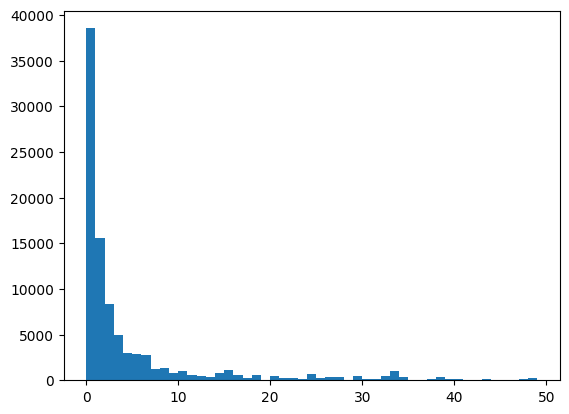

In [7]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
bins=list(range(0,50,1))
ax.hist(unlabeled_df['gh_stars'],bins=bins,density=False, histtype='bar',label='histogram bins')
# ax.axvline(x=unlabeled_df['no_lines'].mean(),ymin=0,ymax=0.2,color='red',linewidth=3.0,label='mean')
# ax.axvline(x=unlabeled_df['no_lines'].median(),ymin=0,ymax=0.2,color='orange',linewidth=3.0,label='median')
# ax.set_xticks(list(range(0,2501,500)))
# ax.set_xlabel('lines')
# ax.set_ylabel('files')
# ax.text(combined_df['no_lines'].median(),4500,str(int(combined_df['no_lines'].median())),color='orange',ha='center',weight='heavy')
# ax.text(combined_df['no_lines'].mean(),4500,str(int(combined_df['no_lines'].mean())),color='red',ha='center',weight='heavy')
# ax.legend()
# fig.savefig("number_of_lines.png",dpi=1200)
fig.show()

In [8]:
unlabeled_df['has_snippet'] = unlabeled_df.index.isin(snippets_df['file_index'].astype(str))

In [ ]:
best_unlabeled_df = unlabeled_df[unlabeled_df['has_snippet']]
print(len(best_unlabeled_df))
best_unlabeled_df = best_unlabeled_df[best_unlabeled_df['gh_stars'] > 0]
print(len(best_unlabeled_df))

In [15]:
print(len(best_unlabeled_df))
print(len(best_unlabeled_df)*0.5)
print(len(best_unlabeled_df)*0.15)

57511
28755.5
8626.65


In [19]:
best_unlabeled_df = best_unlabeled_df.sample(frac=1)
eval_unlabeled_df = best_unlabeled_df.iloc[:28756]

In [21]:
val_unlabeled_df = eval_unlabeled_df.iloc[:8627]
test_unlabeled_df = eval_unlabeled_df.iloc[8627:]
train_unlabeled_df = unlabeled_df[~unlabeled_df.index.isin(eval_unlabeled_df.index)]

In [22]:
print(len(train_unlabeled_df),len(val_unlabeled_df),len(test_unlabeled_df))
print(sum([len(train_unlabeled_df),len(val_unlabeled_df),len(test_unlabeled_df)]))

71768 8627 20129
100524


In [23]:
train_unlabeled_df.to_csv("data/train_unlabeled.csv")
val_unlabeled_df.to_csv("data/val_unlabeled.csv")
test_unlabeled_df.to_csv("data/test_unlabeled.csv")

In [24]:
train_labeled_df = snippets_df[snippets_df['file_index'].astype(str).isin(train_unlabeled_df.index)]
val_labeled_df = snippets_df[snippets_df['file_index'].astype(str).isin(val_unlabeled_df.index)]
test_labeled_df = snippets_df[snippets_df['file_index'].astype(str).isin(test_unlabeled_df.index)]

In [25]:
print(len(snippets_df))
print(len(train_labeled_df),len(val_labeled_df),len(test_labeled_df))
print(sum([len(train_labeled_df),len(val_labeled_df),len(test_labeled_df)]))

142283
102265 11811 28207
142283


In [26]:
train_labeled_df.to_csv("data/train_labeled.csv")
val_labeled_df.to_csv("data/val_labeled.csv")
test_labeled_df.to_csv("data/test_labeled.csv")

In [27]:
fraction = 0.1
df_names = ['full_snippets','full_unlabeled','test_labeled','test_unlabeled','train_labeled','train_unlabeled','val_labeled','val_unlabeled']
for df_name in df_names:
    df_path = "data/" + df_name + ".csv"
    df = utils.read_csv(df_path)
    df.sample(frac=fraction).to_csv("data/" + "subset_" + df_name + ".csv")

In [28]:
def process_unlabeled_data(row):
    abstract_code, replaced = utils.abstract_strings(row['code'])
    no_comments_abstract_code = utils.remove_all_comments(abstract_code)
    return utils.recreate_string(no_comments_abstract_code,replaced)

In [29]:
unlabeled_df_names = ['full_unlabeled','test_unlabeled','train_unlabeled','val_unlabeled']
unlabeled_subset_names = ['subset_' + df_name for df_name in unlabeled_df_names]
for df_name in unlabeled_df_names + unlabeled_subset_names:
    print("Processing", df_name)
    df_path = "data/" + df_name + ".csv"
    df = utils.read_csv(df_path)
    df['code'] = df.progress_apply(process_unlabeled_data,axis=1)
    df.to_csv("data/" + 'processed_' + df_name + ".csv")

Processing full_unlabeled


Applying: 100%|██████████| 100524/100524 [01:27<00:00, 1146.38it/s]


Processing test_unlabeled


Applying: 100%|██████████| 20129/20129 [00:12<00:00, 1573.40it/s]


Processing train_unlabeled


Applying: 100%|██████████| 71768/71768 [00:57<00:00, 1255.21it/s]


Processing val_unlabeled


Applying: 100%|██████████| 8627/8627 [00:06<00:00, 1266.01it/s]


Processing subset_full_unlabeled


Applying: 100%|██████████| 10052/10052 [00:06<00:00, 1470.92it/s]


Processing subset_test_unlabeled


Applying: 100%|██████████| 2013/2013 [00:02<00:00, 992.33it/s] 


Processing subset_train_unlabeled


Applying: 100%|██████████| 7177/7177 [00:05<00:00, 1354.61it/s]


Processing subset_val_unlabeled


Applying: 100%|██████████| 863/863 [00:00<00:00, 1395.45it/s]


## Parsable train

In [ ]:
unlabeled_df = utils.read_csv("data/processed_train_unlabeled.csv")

In [ ]:
best_unlabeled_df = unlabeled_df
print(len(best_unlabeled_df))

71768


In [ ]:
best_unlabeled_df = best_unlabeled_df[(best_unlabeled_df['icarus_exception'].str.len() < 1) | (best_unlabeled_df['verilator_exception'].str.len() < 1)]

In [ ]:
print(len(best_unlabeled_df))

43236


In [ ]:
best_unlabeled_df.to_csv("data/processed_train_unlabeled_parsable.csv")

In [ ]:
print(len(unlabeled_df[unlabeled_df['has_snippet']]))
print(len(best_unlabeled_df[best_unlabeled_df['has_snippet']]))

65424
42477


## Add part of body to def randomly for test

In [ ]:
test_df = utils.read_csv('data/test_labeled.csv')

In [ ]:
def add_parts_of_body_to_def(row):
    sdef = row['snippet_def']
    sbody = row['snippet_body']
    sdef_lines = sdef.split("\n")
    sbody_lines = sbody.split("\n")
    real_def_len = len([s for s in sdef_lines if len(s) > 5])
    real_body_len = len([s for s in sbody_lines if len(s) > 5])
    real_def_lines = [s for s in sdef_lines if len(re.sub(r"\s","",s)) > 0]
    real_body_lines = [s for s in sbody_lines if len(re.sub(r"\s","",s)) > 0]

    def func(x):
        return max(0,min(5,((x+0.7) // 3) ))
    
    if real_def_len < 10:
        func_val = func(real_body_len)
        ri = random.randint(max(0,func_val-1),func_val)
        return pd.Series(["\n".join(real_def_lines+real_body_lines[:ri]), "\n".join(real_body_lines[ri:])])
    else:
        return pd.Series(["\n".join(real_def_lines), "\n".join(real_body_lines)])

In [ ]:
test_df[['random_snippet_def','random_snippet_body']] = test_df.apply(add_parts_of_body_to_def,axis=1)

In [ ]:
print(len(test_df[(test_df['snippet'].str.len() > 1) & (test_df['random_snippet_def'].str.len() > 1) & (test_df['random_snippet_body'].str.len() > 1)]))
print(len(test_df[(test_df['snippet'].str.len() > 1) & (test_df['snippet_def'].str.len() > 1) & (test_df['snippet_body'].str.len() > 1)]))
print(len(test_df))

28206
28207
28207


In [ ]:
test_df[(test_df['snippet'].str.len() > 1) & (test_df['random_snippet_def'].str.len() > 1) & (test_df['random_snippet_body'].str.len() > 1)].to_csv("data/test_labeled_randomized_pairs.csv")